<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_pytorch_DL/blob/main/20220831_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 손글씨 이미지를 입력받아 숫자 에측
 - 알고리즘 : MLP
 - 문제유형 : 다중분류
 - 평가지표 : CE오차

In [2]:
import matplotlib.pyplot as plt

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 학습용 데이터 평가용 데이터 분리
training_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=True, download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
print(len(training_data), len(test_data))

60000 60000


In [4]:
# training_data의 클래스 확인
training_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [5]:
# training_data의 레이블 확인
training_data.train_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [6]:
# training_data의 데이터 차원 확인
training_data.data.shape

torch.Size([60000, 28, 28])

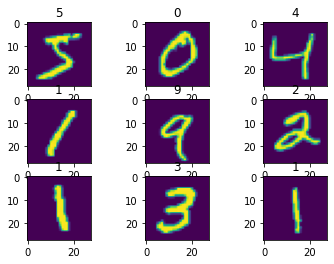

In [7]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(training_data.data[i])
    plt.title(training_data.train_labels[i].item()); # item() : tensor의 값만 가져오기

### 데이터 불러오기 
 - Dataloader() 메서드 : 학습/평가에 사용할 배치를 자동으로 반환
 - 배치 크기, 셔플여부, 사용될 CPU개수 등 설정

In [8]:
from torch.utils.data.dataloader import DataLoader


train_loader = DataLoader(training_data, batch_size=32, shuffle=True) # 학습에 사용되는 데이터는 섞어주자
# training_data의 60000개의 숫자가 0부터 순차적이라면 학습에 문제가 될 것  → 섞어준다


# 평가용 데이터는 학습에 사용되는것이 아니므로 섞을 필요 없음
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
train_loader # 데이터로더는 제너레이터

In [10]:
len(train_loader) # 1875 : 60000개의 이미지를 배치크기(32)로 나누었을 때 1875

1875

In [11]:
dir(train_loader) # __iter__ : iter(데이터로더)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_get_shared_seed',
 '_index_sampler',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [12]:
dir(iter(train_loader)) # __next__, next : 두가지 방식으로 메서드 사용 가능

['_IterableDataset_len_called',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_base_seed',
 '_collate_fn',
 '_dataset',
 '_dataset_fetcher',
 '_dataset_kind',
 '_drop_last',
 '_index_sampler',
 '_next_data',
 '_next_index',
 '_num_workers',
 '_num_yielded',
 '_persistent_workers',
 '_pin_memory',
 '_pin_memory_device',
 '_prefetch_factor',
 '_profile_name',
 '_reset',
 '_sampler_iter',
 '_shared_seed',
 '_timeout',
 'next']

In [13]:
# 1) __next__ 메서드 사용
data, label = next(iter(train_loader))
print(data.shape, label.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [14]:
# 2) next 메서드 사용
data, label = iter(train_loader).next()
print(data.shape, label.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [15]:
import numpy as np
def imshow(img):
    torch_img = img/2 + 0.5 # unnormalize
    np_img = torch_img.numpy() # imshow(np_img)
    plt.imshow(np.transpose(np_img, (1,2,0)))

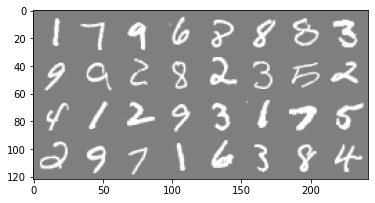

In [16]:
import torchvision
# torchvision.utils.make_grid(data).shape # torch.Size([3, 122, 242]) : RGB, Height, Width
imshow(torchvision.utils.make_grid(data))

### 모델 정의 및 학습하기
 - 이미지 학습에 드는 계산량이 많으므로 GPU 이용

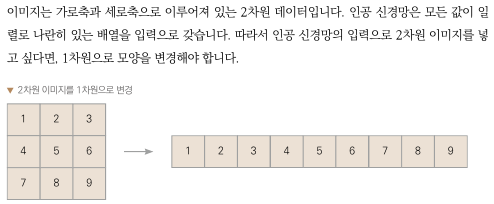

In [17]:
import torch
import torch.nn as nn

from torch.optim.adam import Adam

# 학습에 사용할 프로세서 지정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(nn.Linear(784, 64),   # MNIST의 이미지는 모두 28X28(784픽셀)
                      nn.ReLU(),    
                      nn.Linear(64, 64),
                      nn.ReLU(),  
                      nn.Linear(64, 10))
model.to(device) # 모델의 파라미터를 GPU로 보냄

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)

# 전체데이터를 20번 반복학습
for epoch in range(20):
    for data, labels in train_loader: # len(train_loader) : 1875, 즉 1875회 순회
        
        # data, labels를 GPU로 보냄
        labels = labels.to(device)
        data = data.reshape(-1, 784).to(device) # data가 numpy/tensor배열 일때 reshape 방법
        # data = torch.reshape(data, (-1, 784)).to(device) # data가 tensor 배열 일때 reshape 방법
        
        optim.zero_grad()   # 오차에 대한 각 가중치의 미분값 초기화
        # 입력 데이터 모양을 MLP모델의 입력에 맞게(1차원 벡터) 변환
        preds = model(data)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(preds, labels)
        loss.backward() # 오차에 대한 각 가중치의 미분값 계산 및 저장
        optim.step()    # 가중치 업데이트
    
    print(f'epoch{epoch+1} loss:{loss.item()}')

torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/MNIST.pth") # 파이토치 모델의 파라미터(가중치)를 딕셔너리형태로 저장

epoch1 loss:0.20914782583713531
epoch2 loss:0.017554601654410362
epoch3 loss:0.2010355144739151
epoch4 loss:0.02009125053882599
epoch5 loss:0.007693493738770485
epoch6 loss:0.022336119785904884
epoch7 loss:0.105073943734169
epoch8 loss:0.01797538809478283
epoch9 loss:0.033165521919727325
epoch10 loss:0.00763489818200469
epoch11 loss:0.007844418287277222
epoch12 loss:0.09471486508846283
epoch13 loss:0.000789940357208252
epoch14 loss:0.0001343342592008412
epoch15 loss:0.04885042458772659
epoch16 loss:0.00420689070597291
epoch17 loss:0.010027153417468071
epoch18 loss:0.026068074628710747
epoch19 loss:0.018134787678718567
epoch20 loss:0.00018416292732581496


### 모델 성능 평가하기


In [29]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/MNIST.pth", map_location=device)) # map_location : 불러올 위치

num_corr = 0 # 분류에 성공한 전체 개수 초기화

with torch.no_grad():   # 기울기를 계산하지 않음(학습할때만 손실에 대한 가중치 미분값 계산이 필요)
    for data, label in test_loader:
        data = data.reshape(-1, 784).to(device)
        label = label.to(device)

        preds = model(data) # torch.size([32, 10]) : 배치크기 X 각 레이블(0~10)일 가능성(softmax아니므로 확률은 아님)
        # preds.max(0) : 0차원(각 열에서)의 가장 큰 값(torch.size([10]))과, 인덱스
        # preds.max(1) : 1차원(각 행에서)의 가장 큰 클래스 값(torch.size([32]))과, 인덱스
        # torch.max(preds, dim=1) = preds.max(1)

        # 예측 레이블
        preds = preds.max(1)[1] # 배치내 각 행에서 가장 큰값의 인덱스(0~10까지의 레이블과 같음)

        # 올바르게 분류한 개수
        corr = preds.eq(label).sum().item() # tensor1.eq(tensor2) : True/False의 tensor형식 반환
        num_corr += corr

print(f"Accuracy : {num_corr/len(test_data)}")


Accuracy : 0.9969


In [19]:
a = torch.tensor([0,0,0,0,0,1])
b = torch.tensor([0,0,0,1,0,0])

a.eq(b)

tensor([ True,  True,  True, False,  True, False])

In [20]:
a.eq(b).sum().item()

4

In [24]:
c = torch.tensor([[1,2,3,4,5,6],
                 [2,3,4,5,6,7]])
c.shape

torch.Size([2, 6])

In [25]:
c.max(0)

torch.return_types.max(
values=tensor([2, 3, 4, 5, 6, 7]),
indices=tensor([1, 1, 1, 1, 1, 1]))

In [26]:
c.max(1)

torch.return_types.max(
values=tensor([6, 7]),
indices=tensor([5, 5]))

In [28]:
torch.max(c, dim=1)

torch.return_types.max(
values=tensor([6, 7]),
indices=tensor([5, 5]))

In [32]:
d = np.array([[1,2,3,4,5,6],
              [2,3,4,5,6,7]])
d

array([[1, 2, 3, 4, 5, 6],
       [2, 3, 4, 5, 6, 7]])